# Segment Anything Model (SAM)

In [69]:
from dotenv import load_dotenv
from PIL import Image
from IPython.display import display

import numpy as np
from transformers import SamProcessor, SamModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
load_dotenv(".env")

True

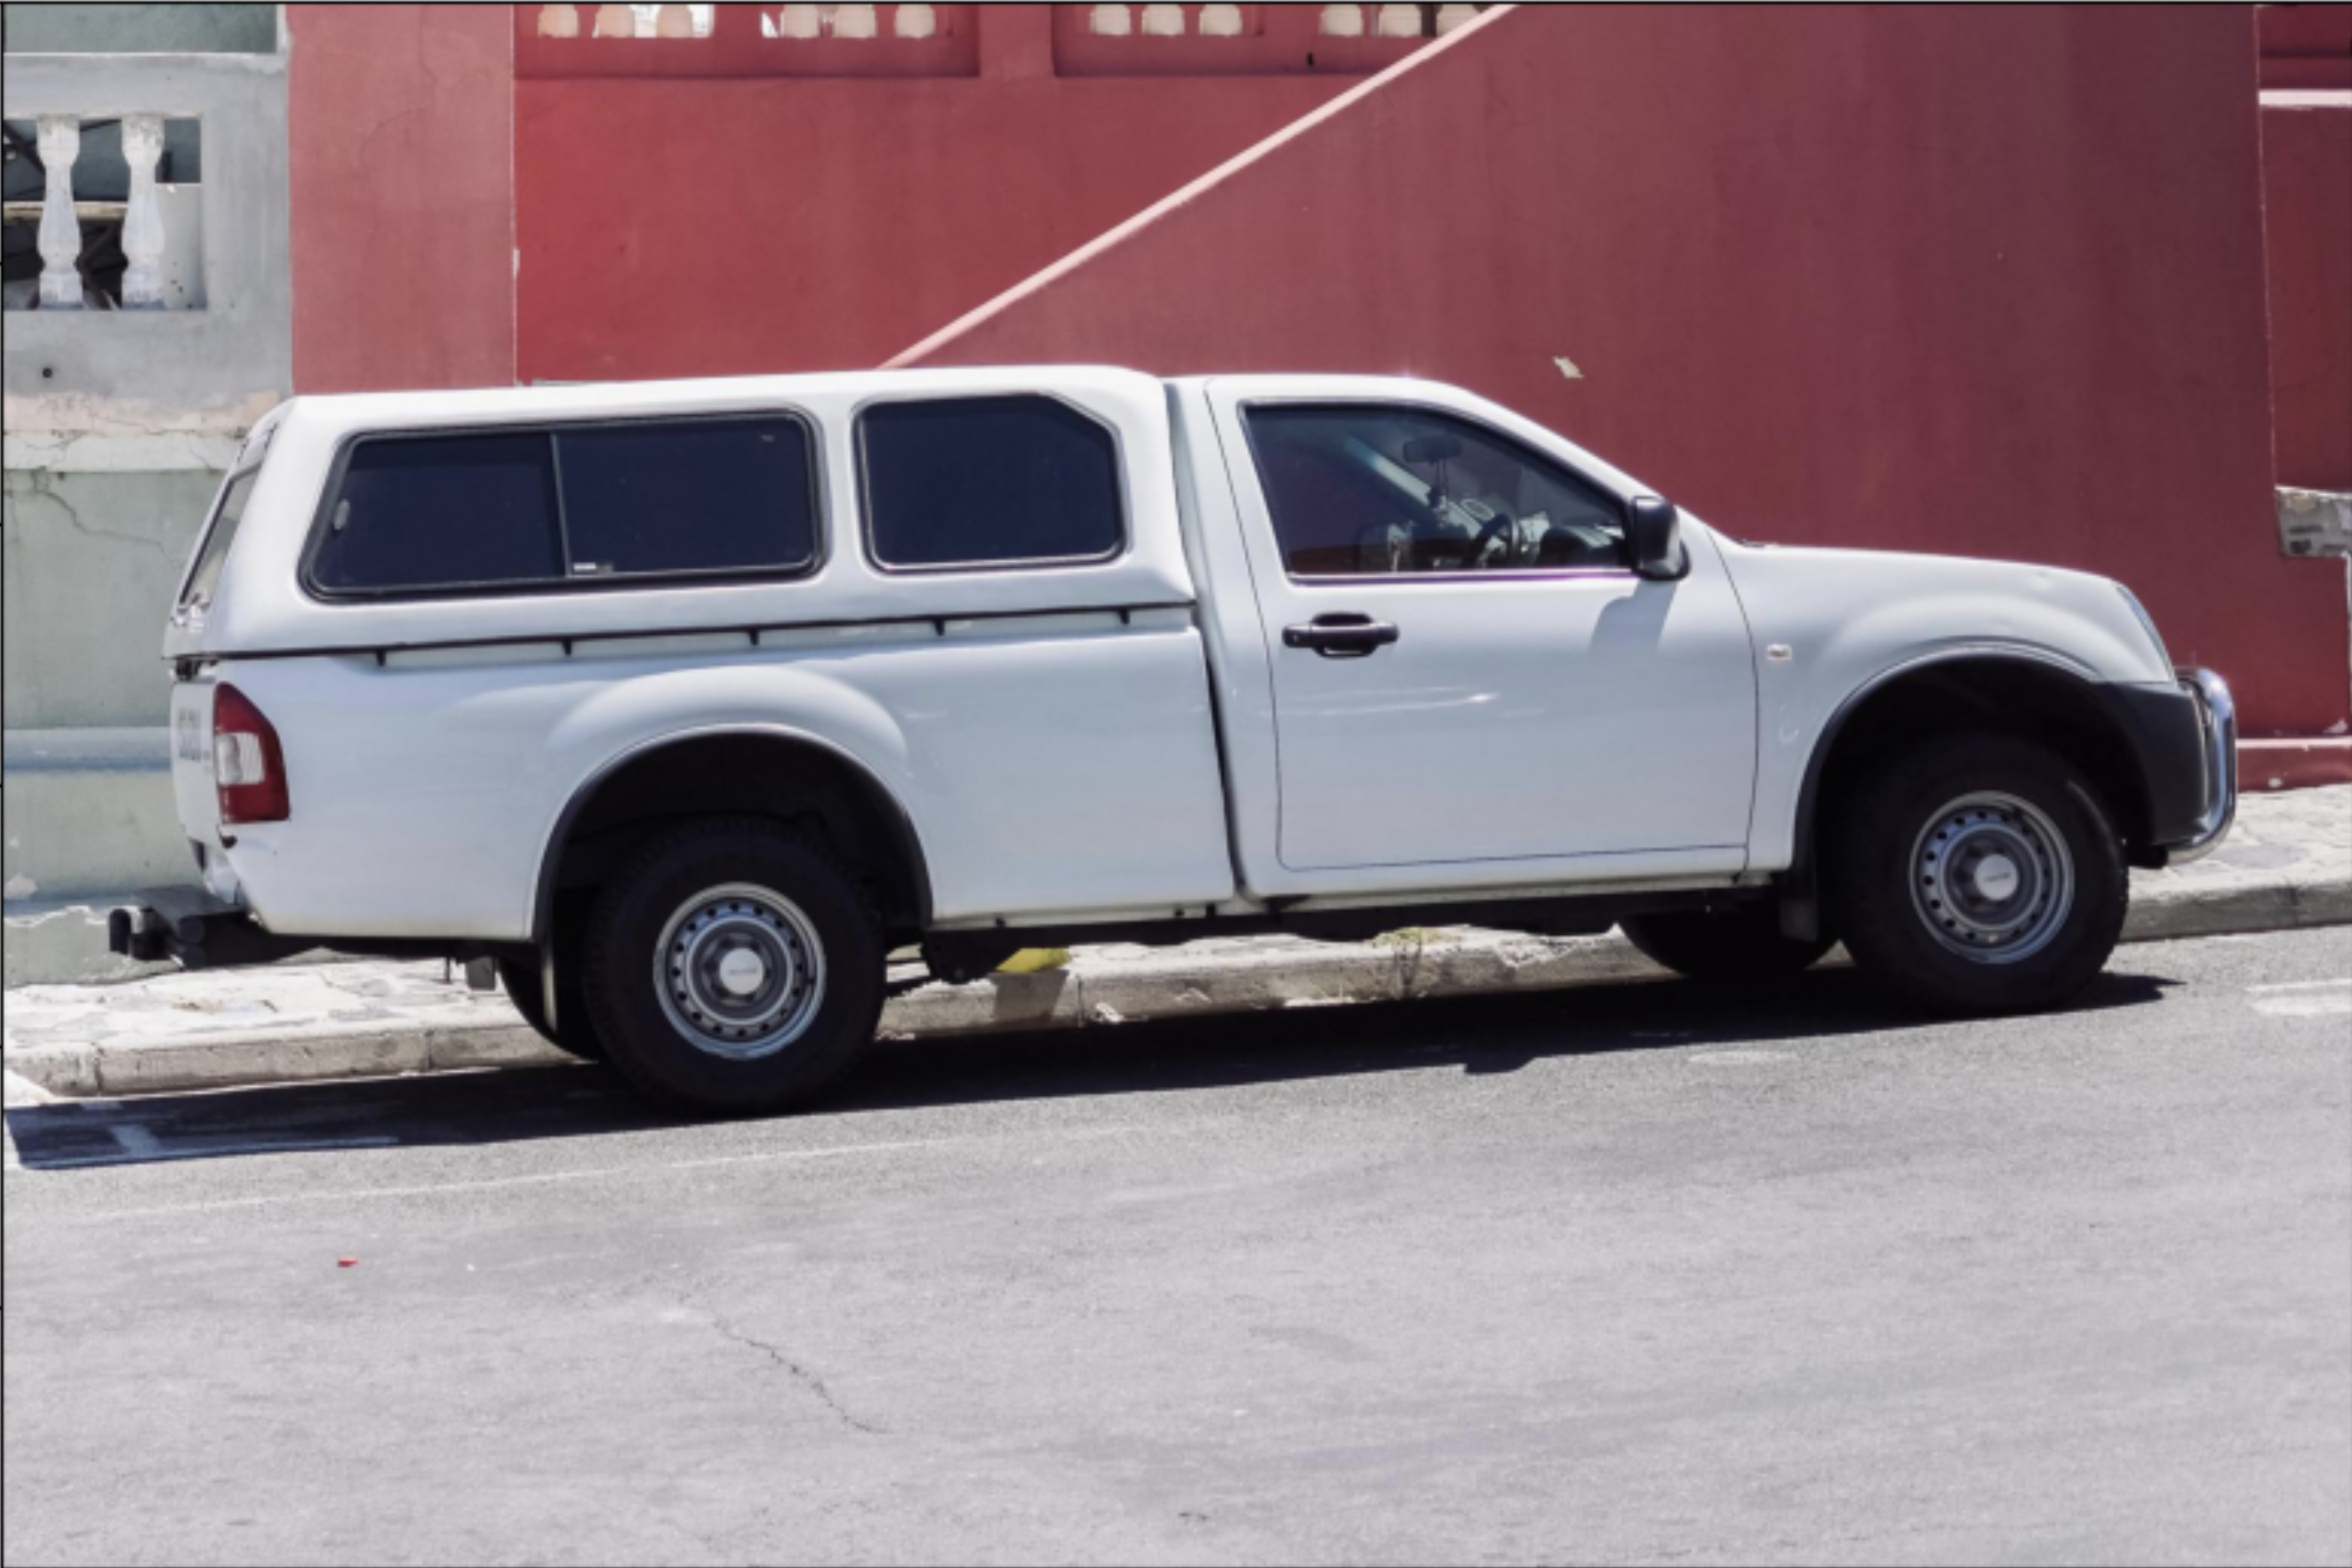

In [60]:
# Open image
image = Image.open("../assets/car.png").convert("RGB")
display(image)

In [61]:
# Load SAM processor + model
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [62]:
# Define a prompt (here: a single point [x, y])
# Coordinates are in pixel space relative to the image
input_points = [[[450, 600]]] # 2D localization of a window

In [63]:
# Prepare inputs
inputs = processor(
    images=image,
    input_points=input_points,
    return_tensors="pt"
)

# Run model
with torch.no_grad():
    outputs = model(**inputs)

In [64]:
# Input image size: (2646, 1764)
image.size

(2646, 1764)

In [65]:
# These are the scores of the 3 outputs
print(outputs.iou_scores.shape)
print(outputs.iou_scores)

torch.Size([1, 1, 3])
tensor([[[0.9057, 0.9562, 0.9669]]])


In [66]:
# These are the 2 masks detected
# We need to scale them back to the original image size
outputs.pred_masks.shape

torch.Size([1, 1, 3, 256, 256])

In [ ]:
image_np = np.array(image)
print(image_np.shape)  # Should be (height, width, 3) for RGB

(1764, 2646, 3)


Postprocessed masks shape: (3, 1764, 2646)


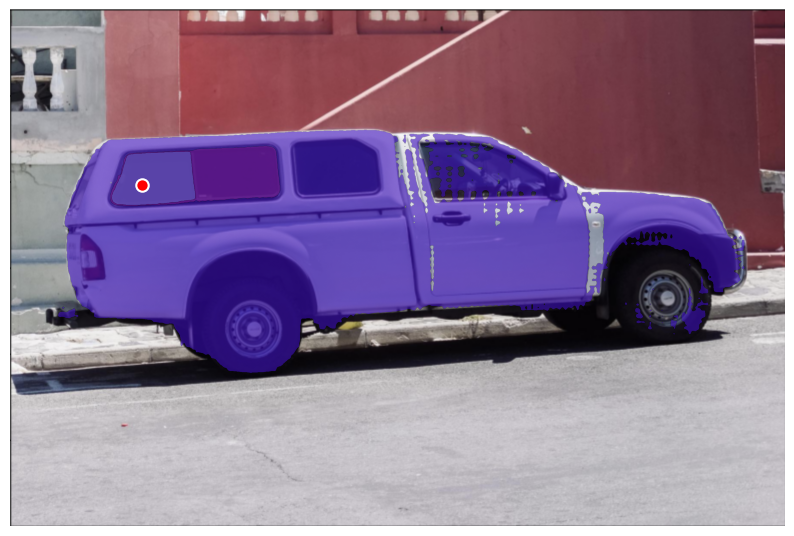

In [82]:
def show_mask(mask, ax, random_color=False):
    """
    Overlay a single binary mask on the given matplotlib axis.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)  # RGBA
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])  # default blue
    
    mask = np.squeeze(mask) # (H, W)
    mask = mask.astype(np.float32) # ensure numeric
    h, w = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Postprocess masks into the original image space
# F.interpolate doesn't work as expected in my case...
# So I ended up using the processor's built-in function
masks = processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)[0].cpu().numpy()

# Drop batch dim -> (num_masks, H, W)
masks = np.squeeze(masks, axis=0)

print("Postprocessed masks shape:", masks.shape)

# Plot image + masks + prompt point(s)
plt.figure(figsize=(10, 10))
# Image
plt.imshow(image_np)
ax = plt.gca()
# Show masks
for mask in masks:
    show_mask(mask, ax=ax, random_color=True)

# Add the red sphere at the prompt point(s)
for (x, y) in input_points[0]:
    ax.scatter(x, y, c="red", s=80, marker="o", edgecolors="white", linewidths=1.5)

plt.axis("off")
plt.show()